In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
import bokeh 

# Getting Data (jhu database)

In [57]:
daily_jhu_report_url_base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%s.csv"
def gather_daily_jhu_reports(date_rng):
    collected = pd.DataFrame()
    for date in date_rng:
        date_str = date.strftime("%m-%d-%Y")
#         print("Collecting data from: %s" % date_str)
        try:
            daily_report = pd.read_csv(daily_jhu_report_url_base % date_str)
            daily_report.insert(0, "Date", date)
            daily_report.rename(columns={
                'Country_Region':'Country/Region', 
                "Province_State": "Province/State", 
                "Last_Update": "Last Update",
                "Lat": "Latitude",
                "Long_": "Longitude"
            }, inplace=True)
            collected = pd.concat([collected, daily_report], axis=0, ignore_index=True)
        except:
            print("FAILED TO FETCH DATA FOR: %s" % date_str)
    return collected

In [71]:
report_data = gather_daily_jhu_reports(pd.date_range("1-22-2020", "04-05-2020").to_pydatetime())
report_data.to_csv("daily_jhu_report_data.csv", index=0)

/Users/kunal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [109]:
jhu_data = pd.read_csv("daily_jhu_report_data.csv")
selector = np.logical_or(selector, jhu_data["Province/State"] == "Texas")
jhu_data['Date'] = pd.to_datetime(jhu_data['Date'])
jhu_tx_data = jhu_data[selector]
jhu_tx_data = jhu_tx_data.dropna()
jhu_surround = jhu_data[jhu_data["Province/State"].isin(['Texas', 'New Mexico', 'Oklahoma',
                                                         'Louisiana', 'Arkansas'])]
jhu_surround = jhu_surround.dropna()

In [42]:
def bounding_box(df):
    """
    takes a dataframe and returns the bounding box of the lat and long columns
    """
    txlatmin = jhu_tx_data.Latitude.min()
    txlatmax = jhu_tx_data.Latitude.max()
    txlongmin = jhu_tx_data.Longitude.min()
    txlongmax = jhu_tx_data.Longitude.max()
    return txlatmin, txlatmax,txlongmin,txlongmax

In [8]:
dfw = plt.imread("largerarea.png")

In [9]:
latmin = 32.3304
latmax = 33.3607
longmin = -97.8001
longmax = -96.0354
BBox = (longmin, longmax, latmin, latmax)

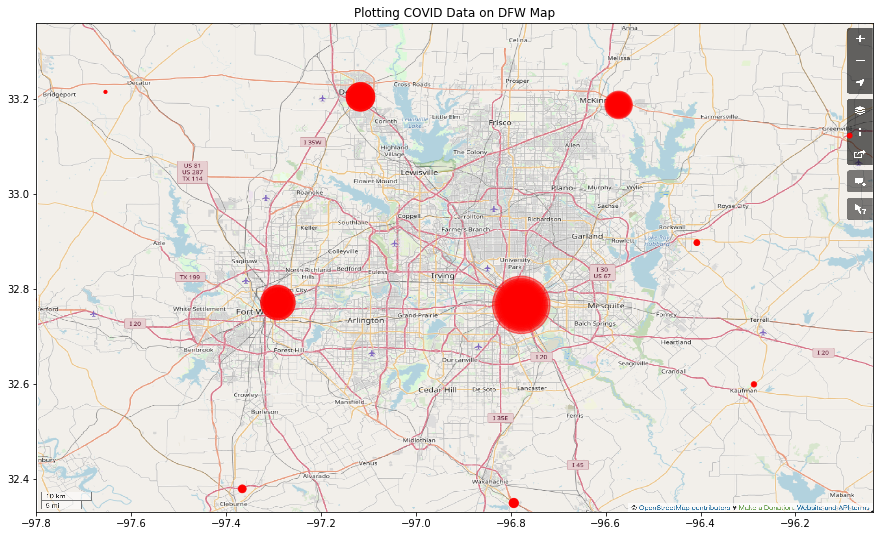

In [10]:
fig, ax = plt.subplots(figsize = (15,48))
ax.scatter(jhu_tx_data.Longitude, jhu_tx_data.Latitude, zorder=1, alpha= 0.5, c='r', s=jhu_tx_data['Confirmed']*3)
ax.set_title('Plotting COVID Data on DFW Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(dfw, zorder=0, extent = BBox, aspect= 'equal')

In [110]:
def covid_cases_map(df, start_date, end_date, states):
    """
    takes df of covid data and returns county mapping of cases in the selected date range
    """
    import plotly
    import plotly.figure_factory as ff
    import plotly.io as pio
    from IPython.display import Image

#     df = jhu_tx_data
#     start_date = "2020-01-22"
#     end_date = "2020-02-03"

    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    df = df.loc[mask]
    confirmed_cases = df['Confirmed'].tolist()
    fips = df['FIPS'].tolist()
    colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(173,174,210)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
    ]

    fig = ff.create_choropleth(
        fips=fips, values=confirmed_cases, scope=states,
        binning_endpoints=[1, 5, 25, 125, 500,1250], colorscale=colorscale,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
        legend_title='Confirmed COVID-19 Cases by County', title='COVID-19 in TX+ from '+ start_date +" to " + end_date
    )
    fig.layout.template = None
    return Image(pio.to_image(fig, format='png'))

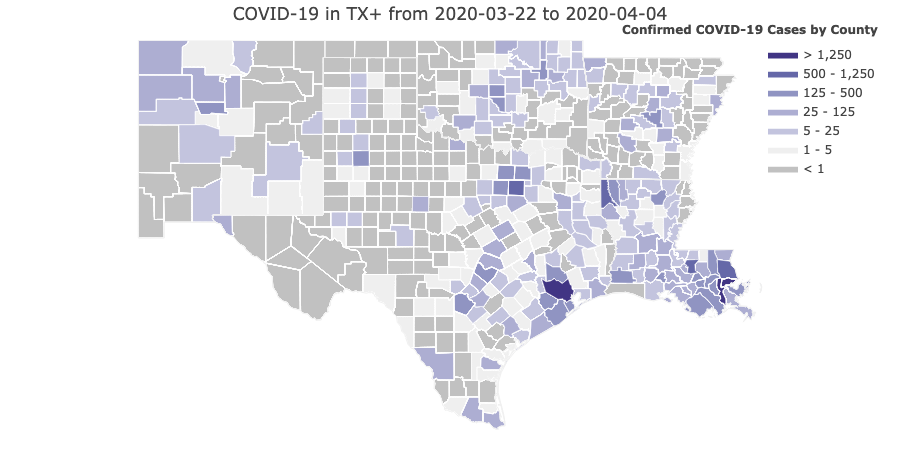

In [114]:
covid_cases_map(jhu_surround, "2020-03-22", "2020-04-04", ['TX', 'NM', 'LA', 'OK', 'AR'])

In [83]:
def county_risk(csvfile):
    """
    provide graph of at risk counties in Texas
    """
    county = pd.read_csv(csvfile)
    county['FIPS'] = county['FIPS'] + 48000
    county = county[~county.County.str.contains("STATE OF TEXAS")]
    county = county[~county.Age.str.contains("All Ages")]
    county = county[~county.Age.str.contains("<")]
    # remove state of texas rows and unnecessary data
    county["Age"] = county["Age"].str.replace("Years", "")
    county["Age"] = county["Age"].str.replace("+", "")
    county["Age"] = pd.to_numeric(county["Age"]) # recast dtype to int
    bins = [0,65,96]
    names = ["<65","65+"]
    test = county
    test['AgeRange'] = pd.cut(test['Age'], bins, labels=names)
    hold = test[['County', 'FIPS', 'AgeRange','Total']]
    total_county = hold[['County','AgeRange','Total', 'FIPS']].groupby(['County', 'FIPS']).sum()
    over65 = hold.loc[hold['AgeRange'] == '65+'].groupby(['County']).sum()
    vulnerable = pd.merge(over65, total_county, how='inner', on = 'County')
    vulnerable['pct_risk'] = vulnerable['Total_x'] / vulnerable['Total_y']
    vulnerable['FIPS'] = vulnerable['FIPS'] / 30
    vulnerable['risk'] = vulnerable['pct_risk'] * 100
    vulnerable_spots = vulnerable['risk'].tolist()
    fips = vulnerable['FIPS'].tolist()

    colorscale = [
        'rgb(193, 193, 193)',
        'rgb(239,239,239)',
        'rgb(195, 196, 222)',
        'rgb(173,174,210)',
        'rgb(144,148,194)',
        'rgb(101,104,168)',
        'rgb(65, 53, 132)', 
        'rgb(243,78,78)',
    ]

    fig = ff.create_choropleth(
        fips=fips, values=vulnerable_spots, scope=['TZ'],
        binning_endpoints=[0, 5, 10, 15, 20, 30, 40], colorscale=colorscale,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
        legend_title='Risk by County Based on Age Distribution (%)', title='COVID-19 Age Risk'
    )
    fig.layout.template = None
    # fig.show()
    return Image(pio.to_image(fig, format='png'))

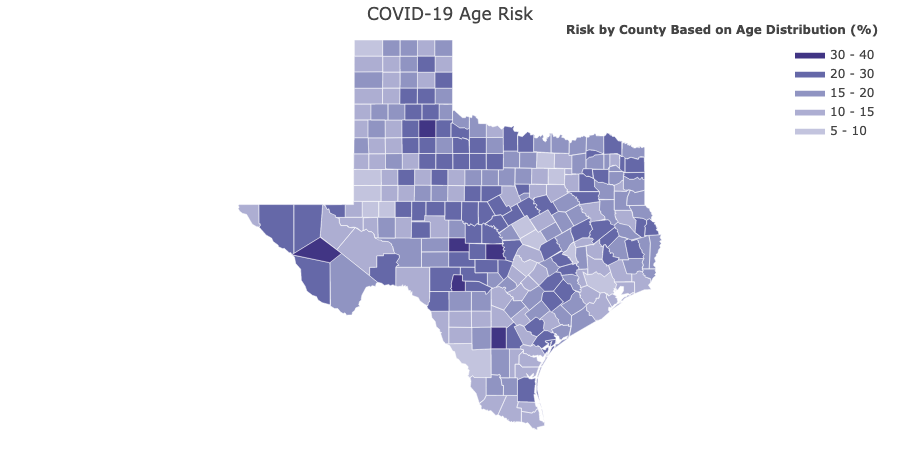

In [84]:
county_risk("alldata.csv")

In [118]:
from IPython.core.display import display, HTML
display(HTML("""<a href="https://imgflip.com/gif/3vjatn">GIF</a>"""))

# Modeling Spread